# 1D time dependent Schrödinger equation 
## Numerical solution
The main goal of this script is to numerically solve the 1D time-dependent Schrödinger equation for a particle that interacts with a potential barrier. The particle (we assume an electron) is best described as a wave packet, so we have to solve the Schrödinger equation for both its spatial and time dependence. We'll use the International System of Units, keeping in mind that the region of confinement is the size of an atom.

We model the electron initially localized in space at $x = x_0$ with momentum $p_0 = \hbar k_0 $ with a wave function that is a gaussian wave packet, defined by: 


\begin{equation}
\psi(x,t=0) = \text{e}^{i k_0 x} \cdot \text{e}^{-\frac{(x-x_0)^2}{2\sigma^2}}
\end{equation}

We define the parameters of the wave packet: 

In [2]:
# Fundamental constants
h_bar = 1.055e-34
m = 9.11e-31 # electron mass
# Sigma in metres:
sigma = (20)*1e-10
# Initial position of wave packet: 
x0 = 150 * 1e-10
# Initial wave-vector in reciprocal metres:
k0 = 2*1e10
# Initial momentum & velocity 
p0 = k0 * h_bar
v0 = p0 / m
# Initial Energy  in J 
E0 = (k0 * h_bar)**2 / (2 * m)

The time and space evolution of a quantum particle is described by the 1D time-dependent Schrödinger equation: 
\begin{equation}
i \hbar \frac{\partial \psi(x,t)}{\partial t} = H \psi(x,t) \quad\quad\quad  H = \frac{-\hbar^2}{2m}\frac{\partial ^2}{\partial x^2} + V(x)
\end{equation}
Where the Hamiltonian $H$ is time-independent and $x \in [0,L]$ (the particle is confined in a box). We shall consider the following boundary conditions: $\psi(0,t)=\psi(L,t)=0$. Putting together the equations we get: 
\begin{equation}
i \hbar \frac{\partial \psi(x,t)}{\partial t}  = \frac{-\hbar^2}{2m}\frac{\partial ^2}{\partial x^2} \psi(x,t) + V(x)\psi(x,t) 
\end{equation}

To solve our 1D PDE numerically, we apply both spatial a time discretization: 
- we divide the x-space up into a grid with $N_x$ points,  with spacing $h$;
- we divide the time domain into $N_t$ equally spaced intervals (dt).

We use the Crank-Nicholson algorithm, which is stable, second order accurate in both the $x$ and $t$ directions, and based on using the backward Euler time differences and averaging with the forward Euler time differences.
Therefore we have: 

\begin{equation}
\psi = \frac{\psi_i^{(n)}+\psi_i^{(n+1)}}{2} \\ \quad \quad


\frac{\partial \psi}{\partial t} = \frac{\psi_{i}^{(n+1)} - \psi_{i}^{(n)}}{dt} \\ \quad \quad


\frac{\partial \psi}{\partial x} = \frac{\psi_{i+1}^{(n)}-\psi_{i-1}^{(n)}+\psi_{i+1}^{(n+1)}-\psi_{i-1}^{(n+1)}}{4h} \\\quad \quad


\frac{\partial^2 \psi}{\partial x^2} = \frac{\psi_{i+1}^{(n)} - 2 \psi_{i}^{(n)} + \psi_{i-1}^{(n)} + \psi_{i+1}^{(n+1)} -2 \psi_{i}^{(n+1)} + \psi_{i-1}^{(n+1)} }{2h^2} \\

\end{equation} 



with $\psi_i^{(n)} = \psi(x_i,t_n)$ and $t_n = t_0 + n dt$ $(n = 0,...,N_t)$.




In [3]:
# =============================================================================
# Parameters to solve the equation 
# =============================================================================

# Cell lenght (in meters)
L = 500 * 1e-10
# x domain 
Nx = 1000
h = L/(Nx-1) # There are Nx points and Nx -1 spaces between them 
Nmat = Nx-2 # Useful to set the matrix
# time domain
dt = 1e-16
N_steps = 2000


Substituting the above into the PDE, multiplying through by $ \frac{4mh^2}{\hbar^2}$, collecting all the terms involving the unknown $\psi_{...}^{n+1}$ on the left hand side results in the matrix form: 

\begin{equation}
\sum_{i,j = 2}^{N_x - 1} M_{ij}\psi_j^{n+1} = F_i  
\end{equation}

\begin{equation}
F_i = \frac{2mh^2}{\hbar^2}V_i \psi_i^{(n)} + i \frac{4mh^2}{\hbar dt} \psi_i^{(n)} - \psi_{i+1}^{(n)} - \psi_{i-1}^{(n)} + 2 \psi_{i}^{(n)} \\

M_{ij} = 
\begin{cases}
i\frac{4mh^2}{\hbar dt} - 2 - \frac{2mh^2}{\hbar^2}V_i && \text{if} & j = i\\
    1 && \text{if} & j = i+1\\
    1 && \text{if} & j = i-1\\
    0 && \text{otherwise}
\end{cases}
\end{equation}


In [4]:
# =============================================================================
# Libraries
# =============================================================================

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from matplotlib import animation
import cmath


At this point we have equations that are in the standard $M \textbf{a} = \textbf{b}$ form with $M$ tridiagonal matrix (zero elements except for the main diagonal and two diagonals on either side of it), so we can use a specific iterative method to obtain our desired solution. Firstly, we define useful coefficients: 
\begin{equation}
\alpha_i = \left ( \frac{M_{i,i-1}}{M_{i,i+1} \cdot \alpha_{i-1}} - \frac{M_{i,i}}{M_{i,i+1}}\right)  \\
\beta_i = \left ( \frac{b_i}{M_{i,i+1}} + \frac{M_{i,i-1}}{M_{i,i+1} \frac{\beta_{i-1}}{\alpha_{i-1}}} \right )
\end{equation}

In this way we can find our vector $\textbf{a}$, using the following expression: 

\begin{equation}
a_{N} = \left (\frac{b_N}{M_{N,N-1}} + \frac{\beta_{N-1}}{\alpha_{N-1}} \right ) \cdot \left ( \frac{1}{\alpha_{N-1}} + \frac{M_{N,N}}{M_{N,N-1}} \right )^{-1}
\end{equation}

In the script we define the terms on the main diagonal $M_{i,i}$ as $\textit{diag}$, then  $M_{i,i+1}$ as $\textit{upper}$ and $M_{i,i-1}$ as $\textit{lower}$.


In [5]:
# =============================================================================
# Tridiagonal solver 
# =============================================================================

def solve(n,diag,upper,lower,b,sol): 
    '''
     function that solves Mx = b where M is a tridiagonal matrix 
     x - initially contains the input vector v, and returns the solution sol
     n - number of equations (length of vector x)
     lower - subdiagonal 
     diag -  main diagonal
     upper - superdiagonal  
     
    '''  
    # Array of zeros to store previously defined coefficients
    alfa = np.zeros(n, dtype=complex)
    beta = np.zeros(n, dtype=complex)
    
    # Initialize first term 
    alfa[0] = -diag[0]/upper[0]
    beta[0] = b[0]/upper[0]

    # Calculate the remaining values 
    for i in np.arange(1,n):
        alfa[i] = (-lower[i-1]/(upper[i]*alfa[i-1])-diag[i]/upper[i])
        beta[i] = b[i]/upper[i]+lower[i-1]*beta[i-1]/(upper[i]*alfa[i-1])
    
    # Calculate first term of the solution, that will be used to iterate the algorythm 
    sol[n-1]=(b[n-1]/lower[n-2]+beta[n-2]/alfa[n-2])/(1./alfa[n-2]+diag[n-1]/lower[n-2])

    # Perform the back substitution to calculate the solution
    for i in np.arange(n-1,0,-1): 
        sol[i-1]=sol[i]/alfa[i-1]-beta[i-1]/alfa[i-1]

    return(sol)


    

Now we get back to the physics! We want to simulate a quantum particle bouncing against a potential barrier $V_0$ so we have to define its height(intensity) and width.

In [6]:
# =============================================================================
# Potential barrier parameters
# =============================================================================

# Specify potential barrier range in x coordinate 
a = 253 * 1e-10
b = 255 * 1e-10

#  Change 'f' to vary the potential barrier height V0: in this way it's easy to check whether E0 < V0 or viceversa 
f  = 0.8
V0 = f * E0


In [7]:
# =============================================================================
# Arrays to store values 
# =============================================================================

psi0 = np.zeros(Nmat, dtype=complex) # Array to store psi at t = 0
psi1 = np.zeros(Nmat, dtype=complex) # Array to store time-evolved psi

# Arrays to store only the non-zeros elements of the matrix 
diag = np.zeros(Nmat, dtype=complex)
upper = np.zeros(Nmat, dtype=complex)
lower = np.zeros(Nmat, dtype=complex)
f = np.zeros(Nmat, dtype=complex) # solution 


In [8]:
# Initialise the wave function with the Gaussian  
norm=0
for i in np.arange(1,Nx-1):
    x = h*i
    psi0[i-1]= np.exp(k0*x*1.0j)*np.exp(-np.power(x-x0,2)/(2*np.power(sigma,2)))
    norm += np.power(np.abs(psi0[i-1]),2) 
norm = norm*L/Nx
norm = np.sqrt(norm)

# Normalize initial wave function 
for i in np.arange(0,Nmat):
    psi0[i]=psi0[i]/norm


In [9]:
# =============================================================================
# Construction of the matrix M and solution of the system 
# =============================================================================

# Set entries above (upper) and below (lower) the main diagonal
for i in np.arange(0,Nmat): 
    upper[i]=1.
    lower[i]=1.
    
# Set entries in the main diagonal
for i in np.arange(0,Nmat): 
    Vx = 0
    x = h*(i+1)
    if x >= a and x <= b:
        Vx = V0
    else:
        Vx= 0
    diag[i]=4.j*m*np.power(h,2)/(h_bar*dt) - 2. - 2*m*np.power(h,2)*Vx / (h_bar**2)


positions = np.zeros(Nmat) # Array to store positions value on the x axis grid

for i in np.arange(0,Nmat):
    x = h*(i+1)
    positions[i] = x

data = np.zeros((Nmat,N_steps)) # Array to store WF at each time step: each column corresponds to a time step (N_steps)
                                # Each row corresponds to the WF at that time step (Nmat) 

# Solve SC. equation for each time step
for n in np.arange(0,N_steps):
    for i in np.arange(1,Nmat-1):
        Vx = 0
        x = h*(i+1)
        if x >= a and x <= b:
            Vx = V0
        else:
            Vx= 0
        f[i] = -psi0[i+1] + 2.*psi0[i] - psi0[i-1] + (4.j*m*np.power(h,2) / (h_bar*dt))*psi0[i] + 2.*m*np.power(h,2)*Vx*psi0[i] / (h_bar**2)

    f[0] = -psi0[1] + 2.*psi0[0] + (4.j*m*np.power(h,2) / (h_bar*dt))*psi0[0] 
    f[Nmat-1] = -psi0[Nmat-2] + 2.*psi0[Nmat-1] +(4.j*m*np.power(h,2) / (h_bar*dt))*psi0[Nmat-1]

    # Solve the equation with the tridiagonal matrix method  
    psi1 = solve(Nmat, diag, upper, lower,f, psi1)

    # Store the WF at this time step
    for i in np.arange(0,Nmat):
        psi0[i] = psi0[i] * np.power(L/Nx,0.5)  # We have to normalize!
        data[i][n]=np.power(np.abs(psi0[i]),2) 
        psi0[i] = psi1[i] # Update WF with the solution for the next step

    # Check if WF is normalized at each time step
    norm = 0.
    for i in np.arange(0,Nmat):
        psi0[i]=psi1[i] # metto i risultati nell'array 
        norm+=pow(abs(psi0[i]),2)
    norm=norm*L/Nx
    #print(n,norm)

## Results and visualization 
Now that we have the PDF that describes our particle, we could study different phenomena associated to it. One of the most unpredicatble ones is the fact that even if the height of the potential barrier is larger than the energy of the particle, a small part of the wave function is able to tunnel through the barrier and reach the other side. Clearly, on atomic scales, just a slight difference in the energy can make a huge difference in terms of trasmission probability. Thus, we want to study how reflection and trasmission probabilities change across time. 



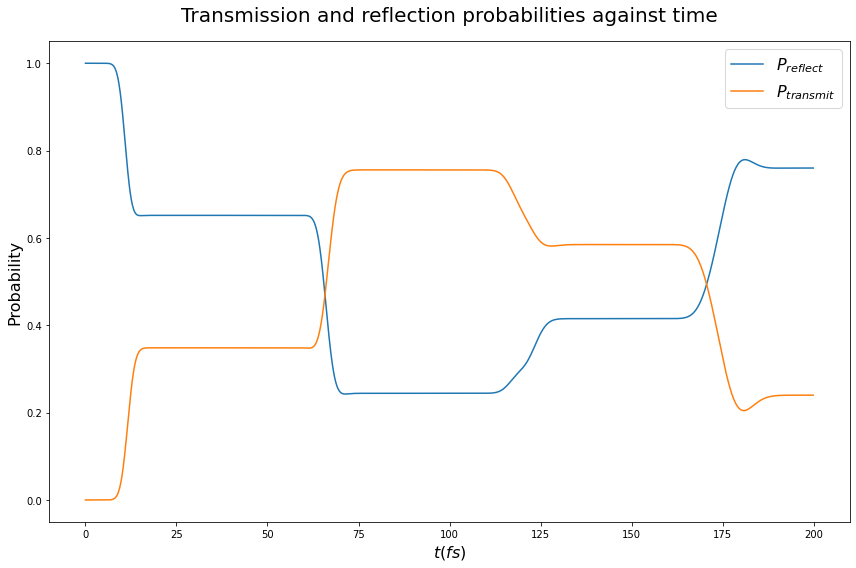

In [11]:
# =============================================================================
# Reflection and Transmission probabilities
# =============================================================================

# Array to store transmission and reflection probability 
P_t = np.zeros(N_steps)  # probability of WF in the x range [b,L]
P_r = np.zeros(N_steps)  # probability of WF in the x range [0,a]

# Indexes that parameterize the range limits in the space of points
i_a = int((Nx-1)* a / (L))
i_b = int((Nx-1)* b / (L))

for n in np.arange(0,N_steps):
    P_r[n] = np.sum(data[0:i_a,n]) # Reflection probability
    P_t[n] = np.sum(data[i_b:,n])  # Transmission probability

# Set the figure
fig = plt.figure(figsize = (12 , 8))
# Set x axis values 
t = np.arange(0,N_steps) * dt * 1e15
# Plot
plt.plot(t , P_r , label = '$P_{reflect}$')
plt.plot(t, P_t , label = '$P_{transmit}$')
plt.ylabel('Probability',fontsize = 16)
plt.xlabel('$t(fs)$',fontsize = 16)
plt.title('Transmission and reflection probabilities against time', fontsize = "20", pad=20 )
plt.tight_layout()
plt.legend(fontsize = 16, loc = "best")
plt.show()
#fig.savefig("TR_coefficients.png", dpi=400)


Last but not least we animate the wavefunction using matplotlib FuncAnimation.

In [ ]:
# =============================================================================
# Animation
# =============================================================================

# Calculate energy and potential in eV
V = V0 / (1.6*1e-19)
E = E0 / (1.6*1e-19) 

# Set the figure
fig = plt.figure(figsize = (12 , 8))

# Set the main plot 
limy = np.amax(data)*0.4 # Adjust y-axis limit in order to have better visualization
ax = plt.axes(xlim=(0, L), ylim=(0, limy))
ax.set_ylabel('$|\psi(x)|^2$',fontsize = 16)
ax.set_xlabel('x(m)',fontsize = 16)
line, = ax.plot([], [], lw=2, color = '#845EC2', label = '$|\psi(x)|^2$') # WF line
title = ax.set_title("")

# Create a second y-axis to visualize the potential 
ax2 = ax.twinx()
lim = E + 5 # Set y-axis limit to be the energy of the particle + 5eV
ax2.set_ylim(0,lim)
ax2.set_ylabel(r'$V\ (eV)$')

# Draw the potential barrier
ax2.vlines(a, 0, V, color='black', zorder=2, label = 'Potential barrier')
ax2.vlines(b, 0, V, color='black', zorder=2)
ax2.hlines(V, a, b, color='black', zorder=2)

# Draw horizontal line to represent the energy of the particle 
ax2.hlines(E,0,a,color='#2C73D2',linestyle = "dashed",lw= 1, zorder=2, label = 'Energy of the particle')
plt.legend(loc = 'best', fontsize = 16)

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

# Animation function
def animate(i):
    x = positions 
    y = data[:,i] # Ad ogni iterazione prendo una colonna cioè un istante temporale 
    line.set_data(x, y)
    time = dt * i
    title.set_text('Elapsed time: {:6.2f} fs'.format(time * 1e+15))
    return line, title

 # Call the animator.  Blit=True means only re-draw the parts that have changed 
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=N_steps, interval=20, blit=True)
#anim.save('PotBarr_1D.mp4', fps=40, extra_args=['-vcodec', 'libx264'],dpi=200)
plt.show()


